# Analysis of sequence co-evolution on PTM cross-talk

## Load functions and data

In [28]:
import numpy as np
from os.path import expanduser

data_dir = expanduser("~") + "/research/PTM-X/"

positive_file = data_dir + "/interface/positive_features_merge.txt"
feature_positive = np.loadtxt(positive_file, delimiter='\t', skiprows=0, dtype="str")

negative_file = data_dir + "/interface/negative_features_merge.txt"
feature_negative = np.loadtxt(negative_file, delimiter='\t', skiprows=0, dtype="str")

In [29]:
feature_positive[0,:]

array(['P12814', 'Y12', 'phosphorylation', 'Q05397', 'Y397',
       'phosphorylation', '1.000', '0.010', '0.333', 'nan'], 
      dtype='|S19')

## Preference on disordered regions

This feature is a binary value: 0 or 1, which means if both PTMs are located in disordered region. DisEMBL v1.5 is used to predict if a residue is located in disordered region. If at least two out of the three build-in predictors predict a residue is in the disordered region, we take the value 1, otherwise 0 for this feature.

In [30]:
from scipy.stats import fisher_exact

disorder_positive = feature_positive[:,6].astype(float)
disorder_negative = feature_negative[:,6].astype(float)

idx1 = disorder_positive == disorder_positive
print("%d positive samples: %.3f samples have both PTMs in disordered region; missing: %.1f%%." 
      %(len(idx1), np.mean(disorder_positive[idx1]), 100-np.mean(idx1)*100))

idx2 = disorder_negative == disorder_negative
print("%d negative samples: %.3f samples have both PTMs in disordered region; missing: %.1f%%." 
      %(len(idx2), np.mean(disorder_negative[idx2]), 100-np.mean(idx2)*100))
    
table = [[sum(disorder_positive[idx1]), sum(idx1)-sum(disorder_positive[idx1])],
         [sum(disorder_negative[idx2]), sum(idx2)-sum(disorder_negative[idx2])]]
p_val = fisher_exact(table)[1]    
print("Fisher exact test p value: %.3f" %(p_val))
print(table)

154 positive samples: 0.240 samples have both PTMs in disordered region; missing: 0.0%.
8433 negative samples: 0.203 samples have both PTMs in disordered region; missing: 0.0%.
Fisher exact test p value: 0.267
[[37.0, 117.0], [1713.0, 6720.0]]


## Sequence co-evolution

This feature is the normalized mutual information between two vector of residues for the according PTM pair. The residue vector is the evolutionary seuqences across multiple vertebrates. Note, the vector is encoded as 1 or 0 as conservation comparing to the residue in human.

In [31]:
import sys
sys.path.append('../scr')
from scipy.stats import ks_2samp
from utils.base import permutation_test

seqCoEvol_positive = feature_positive[:,7].astype(float)
seqCoEvol_negative = feature_negative[:,7].astype(float)

idx1 = seqCoEvol_positive == seqCoEvol_positive
print("%d positive samples: mean nMI: %.3f (median: %.3f); missing: %.f%%." 
      %(len(idx1), np.mean(seqCoEvol_positive[idx1]), np.median(seqCoEvol_positive[idx1]), 100-np.mean(idx1)*100))

idx2 = seqCoEvol_negative == seqCoEvol_negative
print("%d negative samples: mean nMI: %.3f (median: %.3f); missing: %.1f%%." 
      %(len(idx2), np.mean(seqCoEvol_negative[idx2]), np.median(seqCoEvol_negative[idx2]), 100-np.mean(idx2)*100))

print("K-S test p value: %.3f" 
      %(ks_2samp(seqCoEvol_positive[idx1], seqCoEvol_negative[idx2])[1]))
print("Permutation test p value: %.3f" 
      %(permutation_test(seqCoEvol_positive[idx1], seqCoEvol_negative[idx2], 10000)))

154 positive samples: mean nMI: 0.080 (median: 0.019); missing: 36%.
8433 negative samples: mean nMI: 0.059 (median: 0.028); missing: 28.5%.
K-S test p value: 0.025
Permutation test p value: 0.021


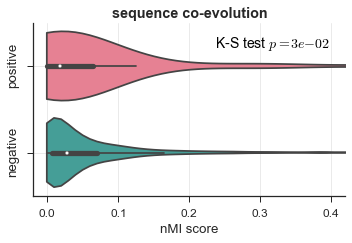

In [32]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def set_style(label_size=12):
    import seaborn
    import matplotlib
    seaborn.set_style("white")
    seaborn.set_style("ticks")

    matplotlib.rcParams['grid.alpha'] = 0.4
    matplotlib.rcParams['xtick.labelsize'] = label_size
    matplotlib.rcParams['ytick.labelsize'] = label_size * 1.1
    matplotlib.rcParams['legend.fontsize'] = label_size * 1.1
    matplotlib.rcParams['axes.labelsize'] = label_size * 1.1
    matplotlib.rcParams['axes.titlesize'] = label_size * 1.2
    matplotlib.rcParams['axes.titleweight'] = 'bold'
    
set_style()

p_val = ks_2samp(seqCoEvol_positive[idx1], seqCoEvol_negative[idx2])[1]

fig = plt.figure(figsize=(5,3.5))
pal = sns.set_palette("husl", 2)

ax = sns.violinplot(data=[seqCoEvol_positive[idx1], seqCoEvol_negative[idx2]], 
                    palette=pal, scale="width", cut=0, orient="h")
# ax = plt.violinplot([seqCoEvol_positive[idx1], seqCoEvol_negative[idx2]])
ax.text(0.95, 0.83, 'K-S test $p= %.e$' %p_val,
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='black', fontsize=14)
plt.xlim(-0.02, 0.42)
plt.xlabel("nMI score")
plt.yticks([0,1], ["positive", "negative"], rotation='vertical')

plt.title("sequence co-evolution")
plt.grid(alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(data_dir + "/figures/seq_CoEvol.pdf")
plt.show()

## PTM co-conservation

In [33]:
import sys
sys.path.append('../scr')
from scipy.stats import ks_2samp
from utils.base import permutation_test

PTMcoEvol_positive = feature_positive[:,8].astype(float)
PTMcoEvol_negative = feature_negative[:,8].astype(float)

idx1 = PTMcoEvol_positive == PTMcoEvol_positive
print("%d positive samples: mean co-convervation: %.3f; missing: %.f%%." 
      %(len(idx1), np.mean(PTMcoEvol_positive[idx1]), 100-np.mean(idx1)*100))

idx2 = PTMcoEvol_negative == PTMcoEvol_negative
print("%d negative samples: mean co-convervation: %.3f; missing: %.1f%%." 
      %(len(idx2), np.mean(PTMcoEvol_negative[idx2]), 100-np.mean(idx2)*100))

print("K-S test p value: %.3f" 
      %(ks_2samp(PTMcoEvol_positive[idx1], PTMcoEvol_negative[idx2])[1]))
print("Permutation test p value: %.3f" 
      %(permutation_test(PTMcoEvol_positive[idx1], PTMcoEvol_negative[idx2], 10000)))

154 positive samples: mean co-convervation: 0.582; missing: 31%.
8433 negative samples: mean co-convervation: 0.485; missing: 19.0%.
K-S test p value: 0.004
Permutation test p value: 0.000


(1.0, 1.0)
(0.76635514018691586, 0.88919789227166279)
(0.48598130841121495, 0.65661592505854804)


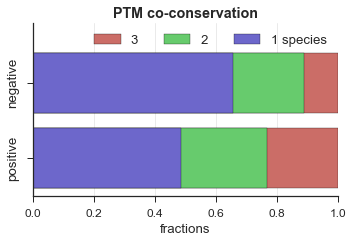

In [34]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

set_style()

pal = sns.color_palette("hls", 3)

fig = plt.figure(figsize=(5,3.5))
_frac1 = sum(PTMcoEvol_positive <= 1.0) / (sum(idx1) + 0.0)
_frac2 = sum(PTMcoEvol_negative <= 1.0) / (sum(idx2) + 0.0)
sns.barplot(data=[[_frac1], [_frac2]], label="3", orient="h", color=pal[0])
print(_frac1, _frac2)

_frac1 = sum(PTMcoEvol_positive <= 0.67) / (sum(idx1) + 0.0)
_frac2 = sum(PTMcoEvol_negative <= 0.67) / (sum(idx2) + 0.0)
sns.barplot(data=[[_frac1], [_frac2]], label="2", orient="h", color=pal[1])
print(_frac1, _frac2)

_frac1 = sum(PTMcoEvol_positive <= 0.34) / (sum(idx1) + 0.0)
_frac2 = sum(PTMcoEvol_negative <= 0.34) / (sum(idx2) + 0.0)
sns.barplot(data=[[_frac1], [_frac2]], label="1 species", orient="h", color=pal[2])
print(_frac1, _frac2)

plt.xlabel("fractions")
plt.yticks([0,1], ["positive", "negative"], rotation='vertical')
plt.title("PTM co-conservation")
plt.grid(alpha=0.4)
sns.despine()
plt.tight_layout()
plt.ylim(-0.5, 1.8)
plt.legend(loc=1, ncol=3)

plt.tight_layout()
plt.savefig(data_dir + "/figures/PTM_CoConsv.pdf")
plt.show()

## PTM co-occurrence

In [8]:
import sys
sys.path.append('../scr')
from scipy.stats import ks_2samp
from utils.base import permutation_test

PTMcoOccur_positive = -np.log10(feature_positive[:,9].astype(float))
PTMcoOccur_negative = -np.log10(feature_negative[:,9].astype(float))

idx1 = PTMcoOccur_positive == PTMcoOccur_positive
print("%d positive samples: mean co-occurrence (-log10 p): %.3f (median: %.3f ); missing: %.f%%." 
      %(len(idx1), np.mean(PTMcoOccur_positive[idx1]), np.median(PTMcoOccur_positive[idx1]), 100-np.mean(idx1)*100))

idx2 = PTMcoOccur_negative == PTMcoOccur_negative
print("%d negative samples: mean co-occurrence (-log10 p): %.3f (median: %.3f); missing: %.1f%%." 
      %(len(idx2), np.mean(PTMcoOccur_negative[idx2]), np.median(PTMcoOccur_negative[idx2]), 100-np.mean(idx2)*100))

print("K-S test p value: %.3f" 
      %(ks_2samp(PTMcoOccur_positive[idx1], PTMcoOccur_negative[idx2])[1]))
print("Permutation test p value: %.3f" 
      %(permutation_test(PTMcoOccur_positive[idx1], PTMcoOccur_negative[idx2], 10000)))

154 positive samples: mean co-occurrence (-log10 p): 3.265 (median: 1.900 ); missing: 77%.
8433 negative samples: mean co-occurrence (-log10 p): 1.612 (median: 1.140); missing: 92.7%.
K-S test p value: 0.008
Permutation test p value: 0.000


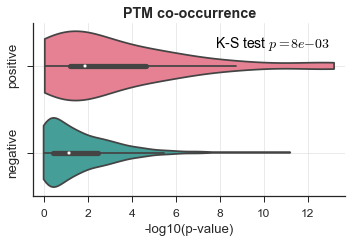

In [9]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

set_style()

p_val = ks_2samp(PTMcoOccur_positive[idx1], PTMcoOccur_negative[idx2])[1]

fig = plt.figure(figsize=(5,3.5))
pal = sns.set_palette("husl", 2)
ax = sns.violinplot(data=[PTMcoOccur_positive[idx1], PTMcoOccur_negative[idx2]], 
                    palette=pal, scale="width", cut=0, orient="h")
ax.text(0.95, 0.83, 'K-S test $p= %.e$' %p_val,
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='black', fontsize=14)

plt.xlim(-0.5, 13.7)
plt.xlabel("-log10(p-value)")
plt.yticks([0,1], ["positive", "negative"], rotation='vertical')
plt.title("PTM co-occurrence")
plt.grid(alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(data_dir + "/figures/PTM_CoOccur.pdf")
plt.show()